In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:

csv_path = "/content/drive/MyDrive/crypto_data_updated_27_august (1).csv"


In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Adj Close (BNB),Volume (BNB),Adj Close (BTC),Volume (BTC),Adj Close (USDT),Volume (USDT),Adj Close (ETH),Volume (ETH)
22,2017-01-12,2.07023,28867200,10975.599609,6783119872,1.009780,749395968,466.540009,1247879936
23,2017-02-12,2.08416,24332700,11074.599609,5138500096,0.999654,679950016,463.449005,943649984
24,2017-03-12,2.22725,35163500,11323.200195,6608309760,1.000660,946748992,465.852997,990556992
25,2017-04-12,2.49168,41226200,11657.200195,6132409856,1.003670,668510016,470.204010,1005550016
26,2017-05-12,2.59530,49190000,11916.700195,6895260160,1.001970,814145984,463.281006,1216720000


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.shape

(1753, 9)

In [ ]:
new_data = df.rename(columns = {"Adj Close (BNB)": "CloseBNB",
                                  "Adj Close (BTC)":"CloseBTC",
                                  "Adj Close (USDT)": "CloseUSDT",
                                  "Adj Close (ETH)": "CloseETH"})

Text(0, 0.5, 'Close Price (USD)')

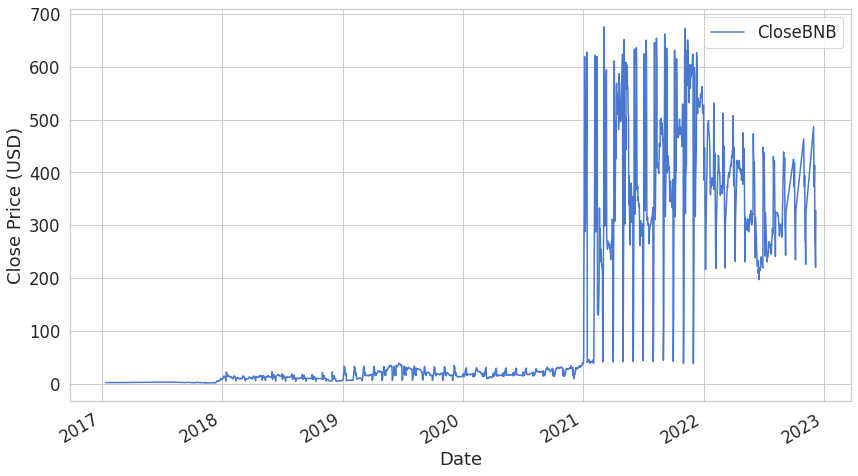

In [ ]:
ax = new_data.plot(x='Date', y='CloseBNB');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

Text(0, 0.5, 'Close Price (USD)')

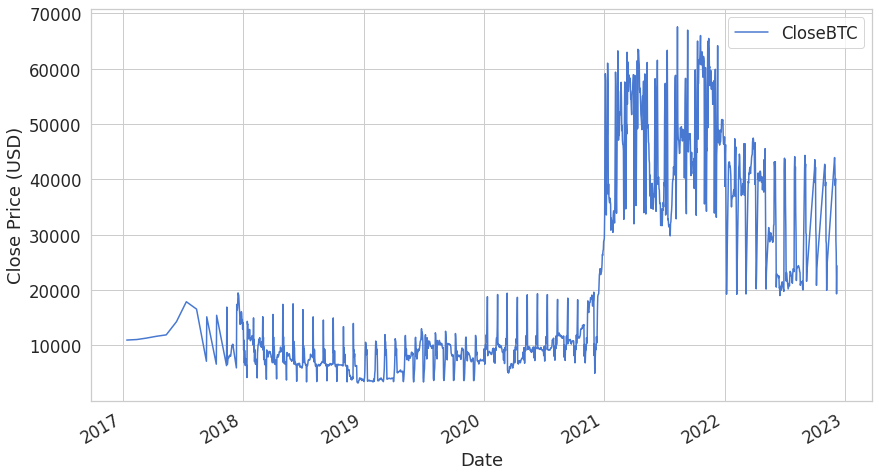

In [ ]:
ax = new_data.plot(x='Date', y='CloseBTC');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

Text(0, 0.5, 'Close Price (USD)')

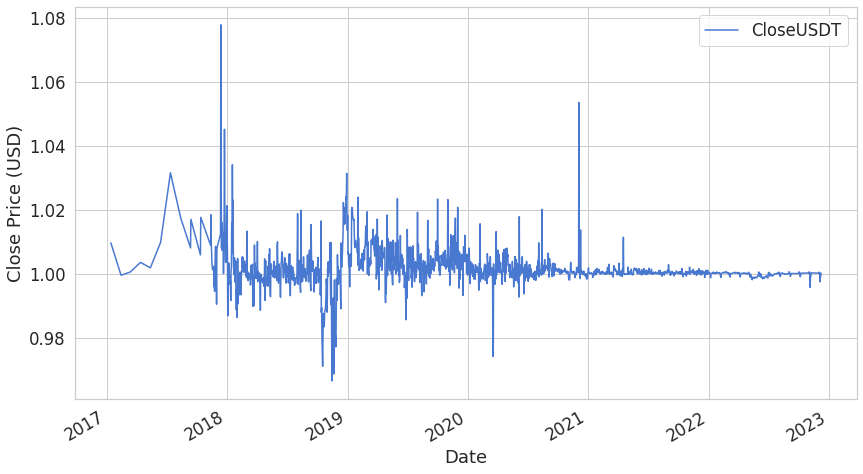

In [ ]:
ax = new_data.plot(x='Date', y='CloseUSDT');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

Text(0, 0.5, 'Close Price (USD)')

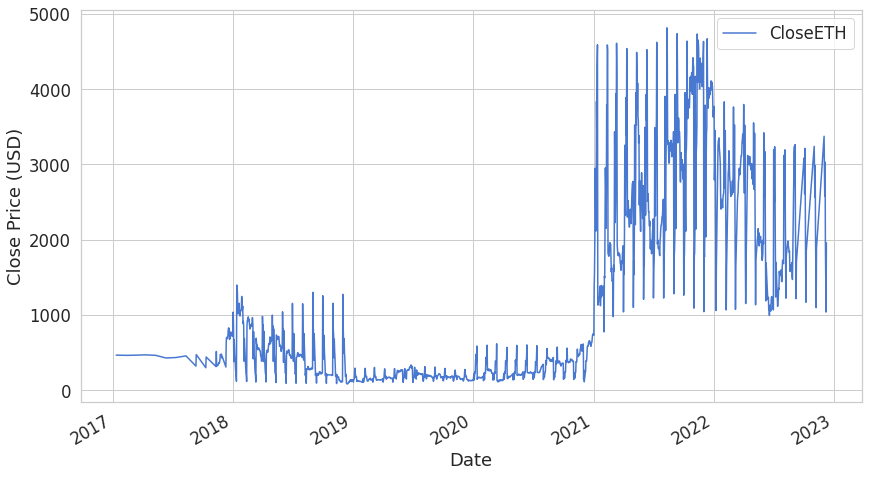

In [ ]:
ax = new_data.plot(x='Date', y='CloseETH');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# BITCOIN

In [ ]:
scaler = MinMaxScaler()

close_price = new_data.CloseBTC.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(1753, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

        

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape


(83, 99, 1)

In [ ]:
X_test.shape

(83, 99, 1)

In [ ]:
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import CuDNNLSTM

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
23/23 [==============================] - 10s 83ms/step - loss: 0.0281 - val_loss: 0.0123
Epoch 2/50
23/23 [==============================] - 1s 43ms/step - loss: 0.0417 - val_loss: 0.0273
Epoch 3/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0369 - val_loss: 0.1285
Epoch 4/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0468 - val_loss: 0.1195
Epoch 5/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0308 - val_loss: 0.0299
Epoch 6/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0183 - val_loss: 0.0268
Epoch 7/50
23/23 [==============================] - 1s 43ms/step - loss: 0.0161 - val_loss: 0.0243
Epoch 8/50
23/23 [==============================] - 1s 43ms/step - loss: 0.0262 - val_loss: 0.0290
Epoch 9/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0299 - val_loss: 0.0160
Epoch 10/50
23/23 [==============================] - 1s 43ms/step - loss: 0.0195 - val_loss: 0.0103
Epoch 11

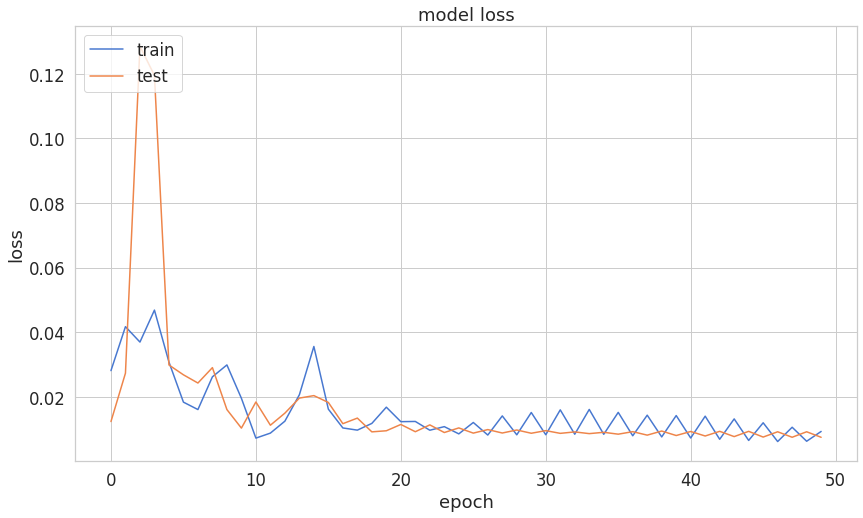

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

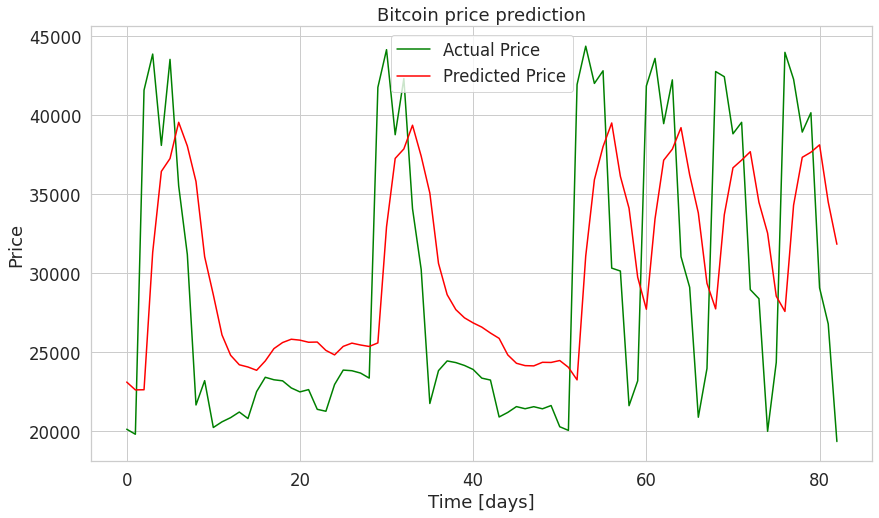

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

### BNB

In [ ]:
scaler = MinMaxScaler()

close_price = new_data.CloseBNB.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

scaled_close = scaled_close[~np.isnan(scaled_close)]

scaled_close = scaled_close.reshape(-1, 1)

np.isnan(scaled_close).any()







False

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))



In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
23/23 [==============================] - 5s 76ms/step - loss: 0.0315 - val_loss: 0.0155
Epoch 2/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0406 - val_loss: 0.1363
Epoch 3/50
23/23 [==============================] - 1s 43ms/step - loss: 0.0435 - val_loss: 0.1725
Epoch 4/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0325 - val_loss: 0.0111
Epoch 5/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 6/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0175 - val_loss: 0.0140
Epoch 7/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0143 - val_loss: 0.0083
Epoch 8/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0193 - val_loss: 0.0209
Epoch 9/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0427 - val_loss: 0.0581
Epoch 10/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0310 - val_loss: 0.1689
Epoch 11/

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 16ms/step - loss: 0.0092


0.009217087179422379

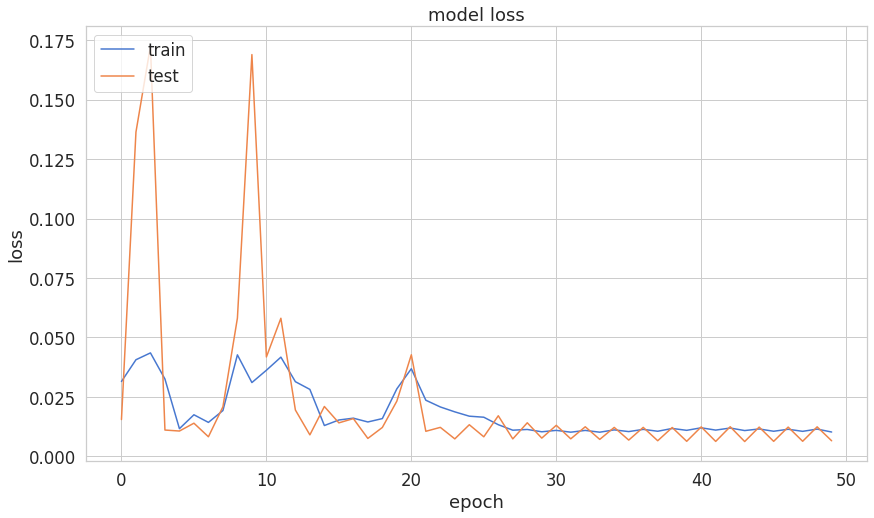

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

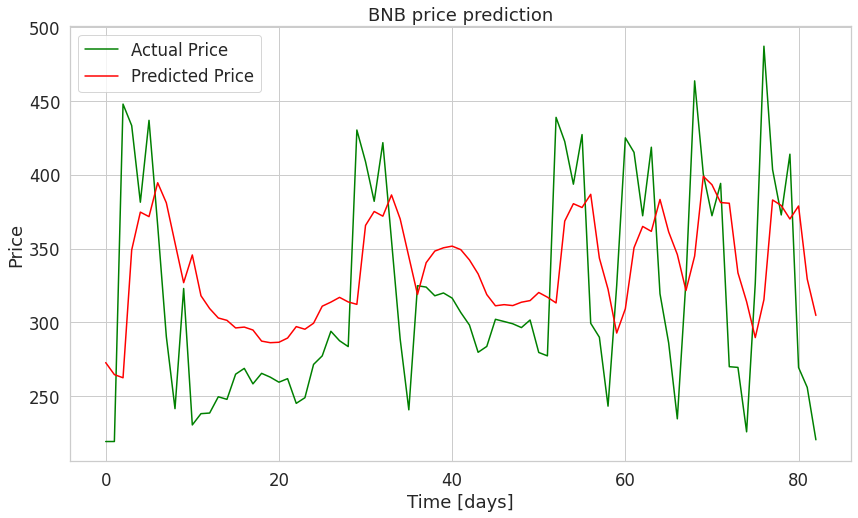

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('BNB price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

### USDT

In [ ]:
scaler = MinMaxScaler()

close_price = new_data.CloseUSDT.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

scaled_close = scaled_close[~np.isnan(scaled_close)]

scaled_close = scaled_close.reshape(-1, 1)

np.isnan(scaled_close).any()

False

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)



In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))


In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
23/23 [==============================] - 11s 81ms/step - loss: 0.0150 - val_loss: 4.6795e-05
Epoch 2/50
23/23 [==============================] - 2s 74ms/step - loss: 0.0023 - val_loss: 5.2591e-05
Epoch 3/50
23/23 [==============================] - 3s 117ms/step - loss: 0.0023 - val_loss: 4.6743e-05
Epoch 4/50
23/23 [==============================] - 2s 109ms/step - loss: 0.0022 - val_loss: 1.0807e-04
Epoch 5/50
23/23 [==============================] - 2s 98ms/step - loss: 0.0022 - val_loss: 1.7621e-04
Epoch 6/50
23/23 [==============================] - 2s 71ms/step - loss: 0.0021 - val_loss: 1.8214e-04
Epoch 7/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0021 - val_loss: 2.0765e-04
Epoch 8/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0021 - val_loss: 2.3300e-04
Epoch 9/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0020 - val_loss: 2.0740e-04
Epoch 10/50
23/23 [==============================] - 2s 67ms/step - lo

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 55ms/step - loss: 2.0795e-04


0.0002079498372040689

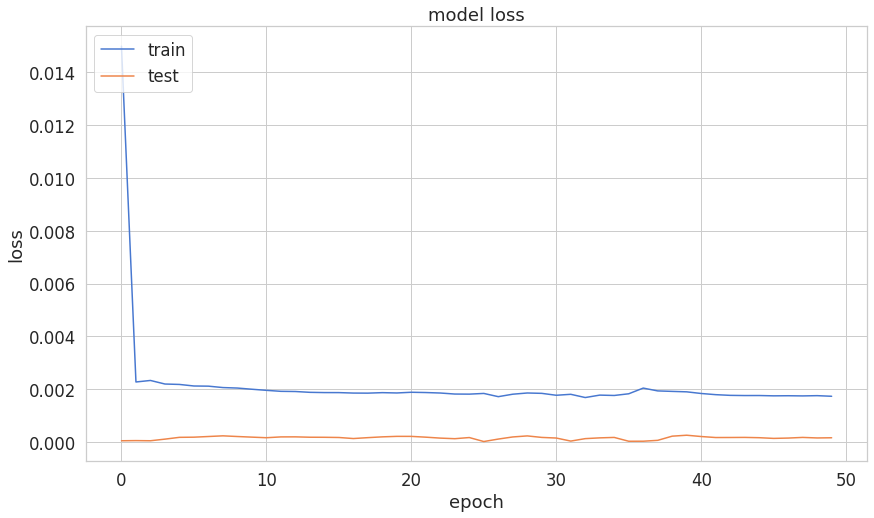

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

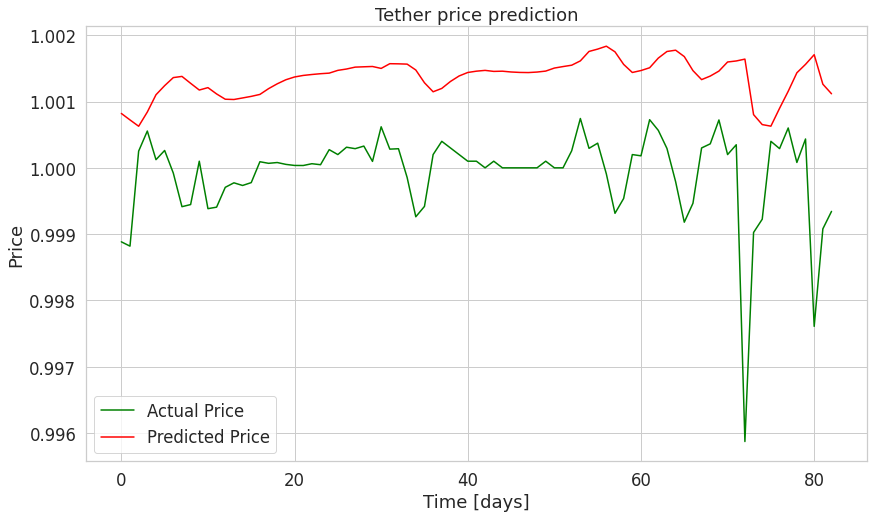

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Tether price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

### ETHEREUM

In [ ]:
scaler = MinMaxScaler()

close_price = new_data.CloseETH.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

scaled_close = scaled_close[~np.isnan(scaled_close)]

scaled_close = scaled_close.reshape(-1, 1)

np.isnan(scaled_close).any()

False

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)



In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
23/23 [==============================] - 11s 79ms/step - loss: 0.0246 - val_loss: 0.0212
Epoch 2/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0307 - val_loss: 0.0944
Epoch 3/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0377 - val_loss: 0.2747
Epoch 4/50
23/23 [==============================] - 1s 42ms/step - loss: 0.0529 - val_loss: 0.1975
Epoch 5/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0335 - val_loss: 0.0351
Epoch 6/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0098 - val_loss: 0.0144
Epoch 7/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0107 - val_loss: 0.0340
Epoch 8/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0172 - val_loss: 0.0212
Epoch 9/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0250 - val_loss: 0.0147
Epoch 10/50
23/23 [==============================] - 1s 41ms/step - loss: 0.0302 - val_loss: 0.0336
Epoch 11

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 43ms/step - loss: 0.0213


0.02125941962003708

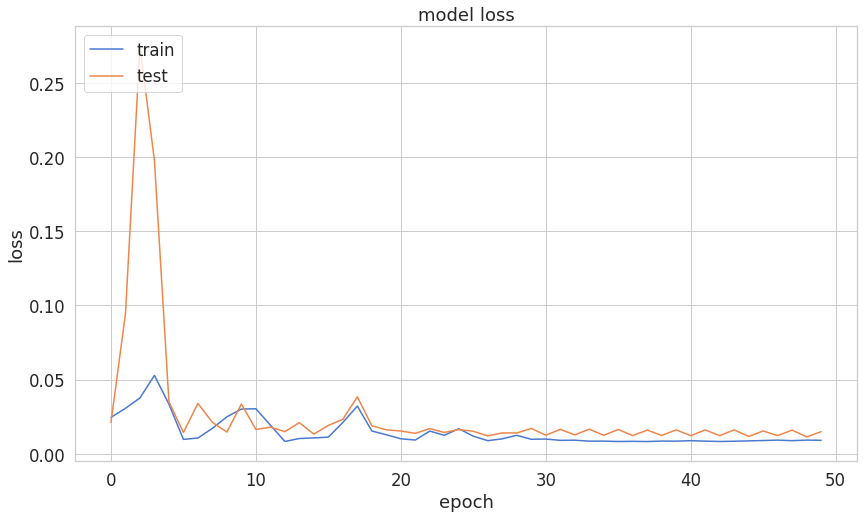

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

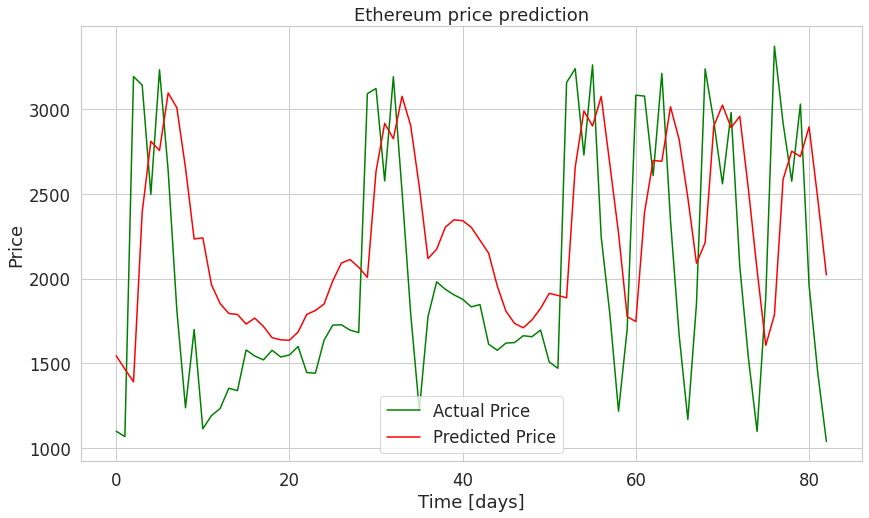

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();